In [1]:
import pandas as pd
import re
from underthesea import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

# Đọc dữ liệu 

In [2]:
train_valid_processed_comments = pd.read_csv("data\\train_valid_processed_comments.csv")
test_processed_comments = pd.read_csv("data\\test_processed_comments.csv")

In [3]:
import ast

# Sử dụng hàm literal_eval để chuyển chuỗi thành danh sách
train_valid_processed_comments['Tokenized_Sentence'] = train_valid_processed_comments['Tokenized_Sentence'].apply(ast.literal_eval)
test_processed_comments['Tokenized_Sentence'] = test_processed_comments['Tokenized_Sentence'].apply(ast.literal_eval)

In [4]:
train_valid_processed_comments.shape

(8624, 4)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
def split_train_valid_test(df_train_valid, df_test, train_size, valid_size, random_state=11):
    X_train, X_valid, y_train, y_valid = train_test_split(
        df_train_valid.drop('Emotion', axis=1),
        df_train_valid['Emotion'],
        test_size=valid_size/(train_size + valid_size),
        random_state=random_state,
        stratify=df_train_valid['Emotion']
    )

    X_test = df_test.drop('Emotion', axis=1)
    y_test = df_test['Emotion']

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [7]:
X_train, X_valid, X_test, y_train, y_valid, y_test = split_train_valid_test(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=7,
    valid_size=3
)

# TF - IDF 

In [8]:
X_train.head(3)

,Sentence,Tokenized_Sentence,tokens_length
3957,mẹ ỉn nhà này cũng vừa đẻ được 3 4 hôm mà nhìn...,"[mẹ, ỉn, nhà, cũng, vừa, đẻ, được, 3, 4, hôm, ...",103
4,nhìn mặt ổng đủ cười chết rồi cười_chảy_nước_mắt,"[nhìn, mặt, ổng, đủ, cười, chết, cười_chảy_nướ...",66
7916,nam chính người nào cũng bị bệnh tự luyến nữa ...,"[nam, chính, người, nào, cũng, bệnh, tự luyến,...",68


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_embedding(tokens, max_features=8000, min_df=2, max_df=0.95):
    # Chuyển đổi danh sách token thành TF-IDF representation
    # max_features : Số lượng từ vựng tối đa mà  (mặc định: 8000)
    # tokens: Danh sách các token

    # Chuyển danh sách token thành chuỗi văn bản
    texts = [' '.join(token_list) for token_list in tokens]

    # Khởi tạo TfidfVectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2), # Sử dụng unigram và bigram
        min_df=min_df,           # Bỏ qua từ xuất hiện < min_df lần
        max_df=max_df         # Bỏ qua từ xuất hiện > max_df documents
    )

    # fit_transform
    # ma trận TF-IDF (n_samples x n_features)
    tfidf_matrix = vectorizer.fit_transform(texts)

    print("TF-IDF hoàn thành!")
    print(f"Shape: {tfidf_matrix.shape} (số câu x số từ vựng)")
    print("Số từ vựng:", len(vectorizer.get_feature_names_out()))
    print("TF-IDF - Non-zero values:", tfidf_matrix.nnz)

    return tfidf_matrix, vectorizer

In [10]:
def tfidf_transform(tokens, tfidf_vectorizer):
    texts = [' '.join(token_list) for token_list in tokens]
    return tfidf_vectorizer.transform(texts)

In [11]:
def convert_to_array(tfidf_matrix):
    return tfidf_matrix.toarray()

In [12]:
# fit_transform
train_tfidf_matrix, train_vectorizer = tfidf_embedding(X_train['Tokenized_Sentence'], max_features=8000, min_df=2, max_df=0.95)

# transform
valid_tfidf_matrix = tfidf_transform(X_valid['Tokenized_Sentence'], train_vectorizer)
test_tfidf_matrix = tfidf_transform(X_test['Tokenized_Sentence'], train_vectorizer)

# Chuyển sang mảng numpy
X_train_arr = convert_to_array(train_tfidf_matrix)
X_test_arr = convert_to_array(test_tfidf_matrix)

TF-IDF hoàn thành!
Shape: (6036, 7991) (số câu x số từ vựng)
Số từ vựng: 7991
TF-IDF - Non-zero values: 68471


# Giảm chiều 

## PCA

In [13]:
from sklearn.decomposition import PCA

### Giảm chiều PCA

In [14]:
# Chọn số chiều để giữ 90%
pca2 = PCA(n_components=0.9)
pca2.fit(X_train_arr)
print(f"Số chiều được PCA chọn để giữ 80% phương sai: {pca2.n_components_}")

Số chiều được PCA chọn để giữ 80% phương sai: 2646


In [15]:
pca = PCA(n_components=2646, random_state=1)
X_train_pca = pca.fit_transform(X_train_arr)

In [16]:
X_train_pca.shape

(6036, 2646)

In [17]:
# Tỉ lệ phương sai giải thích của từng thành phần
print("Tỉ lệ phương sai giải thích cùa 6 thành phần:", pca.explained_variance_ratio_)

# Tổng phương sai giữ lại
print("Tổng phương sai giải thích (phương sai tích lũy):", pca.explained_variance_ratio_.sum())

Tỉ lệ phương sai giải thích cùa 6 thành phần: [5.78277661e-03 4.86192653e-03 4.06104875e-03 ... 7.42693250e-05
 7.41450050e-05 7.38810409e-05]
Tổng phương sai giải thích (phương sai tích lũy): 0.8974339295973888


In [18]:
import matplotlib.pyplot as plt
import numpy as np

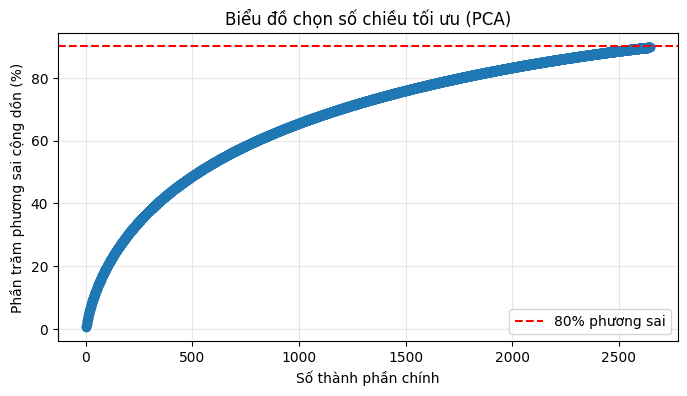

In [ ]:
explained_variance = pca.explained_variance_ratio_ * 100
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8,4))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=90, color='r', linestyle='--', label='990% phương sai')
plt.xlabel('Số thành phần chính')
plt.ylabel('Phần trăm phương sai cộng dồn (%)')
plt.title('Biểu đồ chọn số chiều tối ưu (PCA)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Trực quan theo từng cặp 2 chiều

In [20]:
import seaborn as sns

In [21]:
X_train_pca_df = pd.DataFrame(
    X_train_pca, 
    columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])]
)

# Thêm cột Emotion (nhãn)
X_train_pca_df['Emotion'] = y_train.values

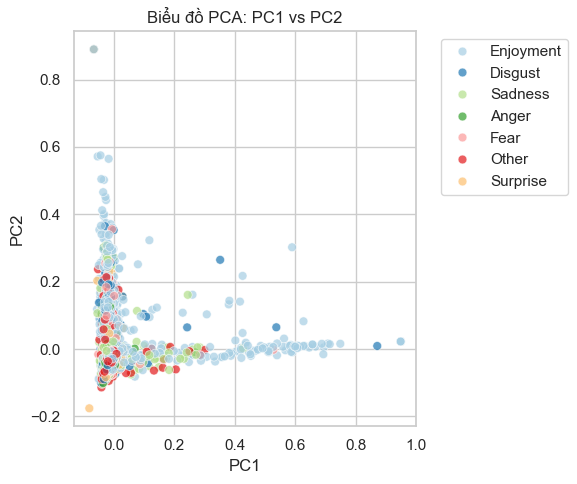

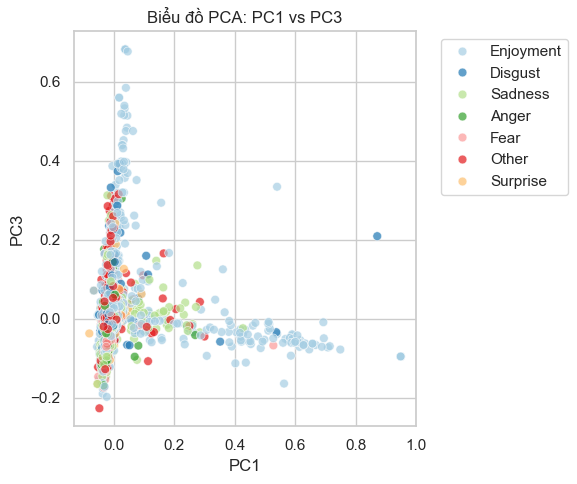

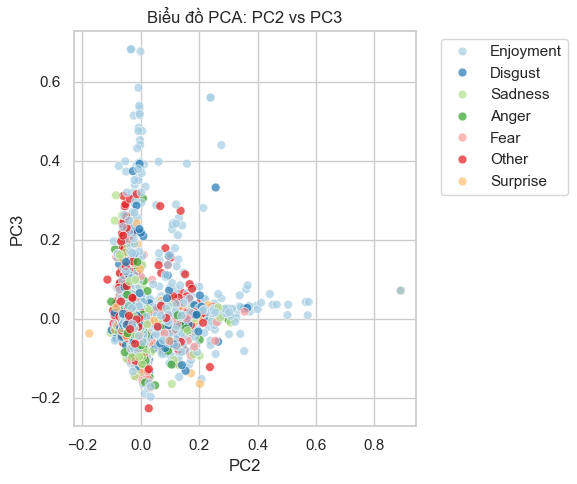

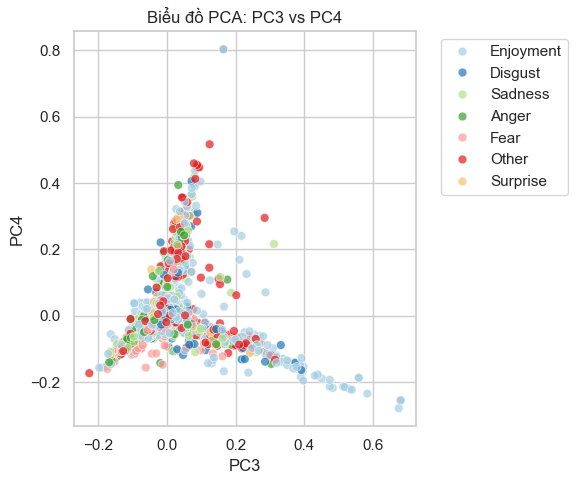

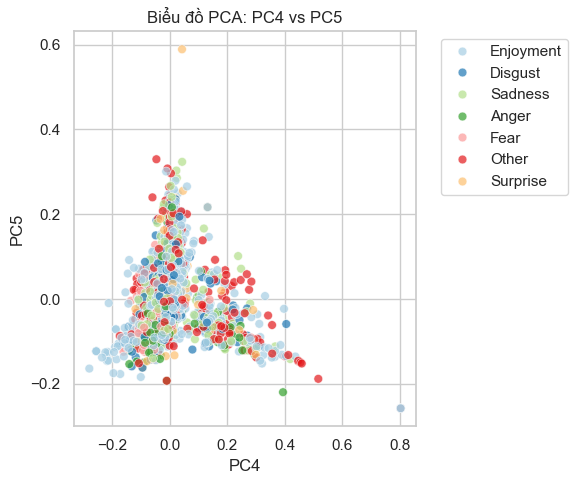

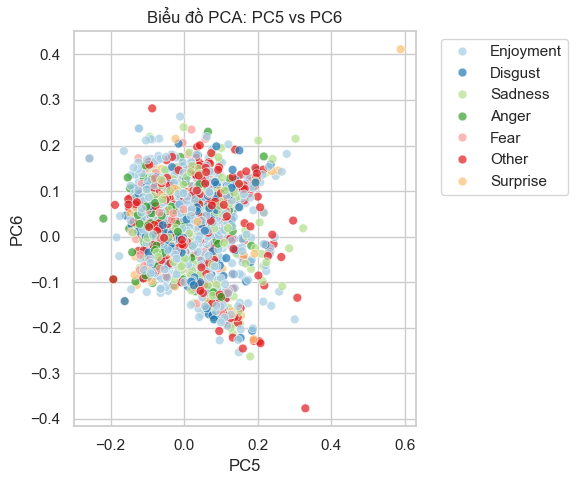

In [22]:
sns.set(style="whitegrid", palette="Paired")     #tab10, Dark2

pairs = [(0,1), (0,2), (1,2), (2,3), (3,4), (4,5)]
for i, j in pairs:
    plt.figure(figsize=(6,5))
    sns.scatterplot(
        data=X_train_pca_df,
        x=f'PC{i+1}', y=f'PC{j+1}',
        hue='Emotion', alpha=0.7, s=40)
    
    plt.title(f'Biểu đồ PCA: PC{i+1} vs PC{j+1}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

Nhận xét: 
- TPC1 và TPC2 chiếm phương sai lớn nhất, nên khi trực quan, ta thấy các label của dữ liệu có xu hướng theo một quy luật nào đó, các cụm ít bị chồng lên nhau hơn.

VD: TPC1 càng tăng thì càng có xu hướng là Anger,.... và ngược lại 

- Còn khi xét các TPC phía sau, nhận thấy DL càng ngày càng có ít xu hướng hơn, các cụm đè lên nhau không theo một quy luật --> không tách biệt được rõ ràng giữa các cụm cảm xúc 

### Vẽ cách 2 (Cách của thầy)

In [23]:
from collections import OrderedDict

In [24]:
# Hàm vẽ scatter plot cho từng cặp
def plot_scatter(pc1, pc2, y, title="PCA Scatter Plot"):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Danh sách nhãn duy nhất
    labels_unique = list(set(y))
    
    # Bảng màu (Pastel1 có sẵn 10 màu đẹp)
    colors = sns.color_palette("muted", n_colors=len(labels_unique))  
    
    for i in range(len(pc1)):
        label = y.iloc[i] if hasattr(y, "iloc") else y[i]
        plt.scatter(pc1[i], pc2[i],
                    s=40,
                    c=[colors[labels_unique.index(label) % len(colors)]],
                    label=label)
    
    # Gộp nhãn trùng trong legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),
               prop={'size': 10}, loc='best')
    
    # Thêm tiêu đề, nhãn trục, và đường chia trục
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Principal Component 1', fontsize=12)
    ax.set_ylabel('Principal Component 2', fontsize=12)
    ax.axhline(y=0, color="grey", linestyle="--", linewidth=0.7)
    ax.axvline(x=0, color="grey", linestyle="--", linewidth=0.7)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

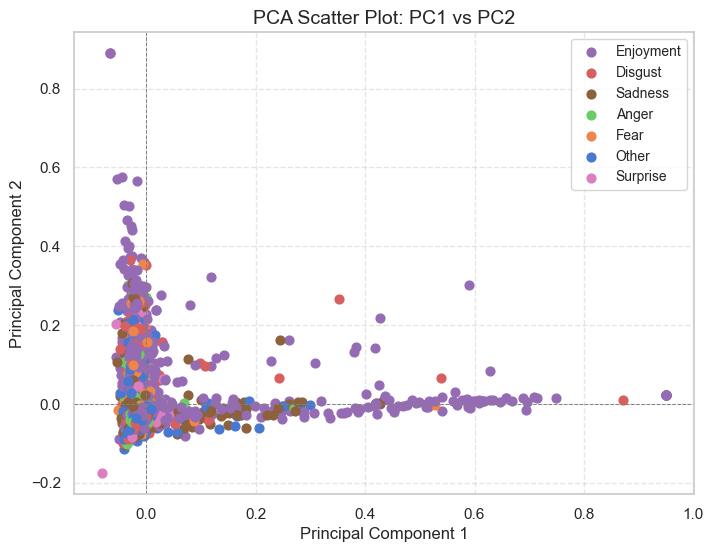

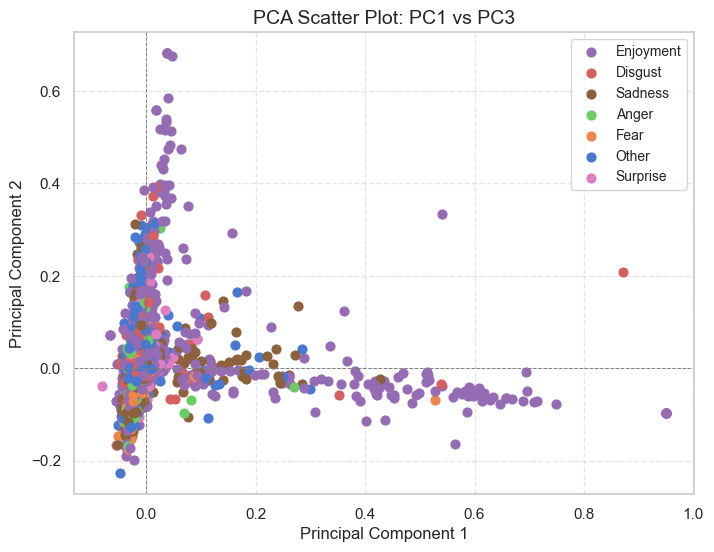

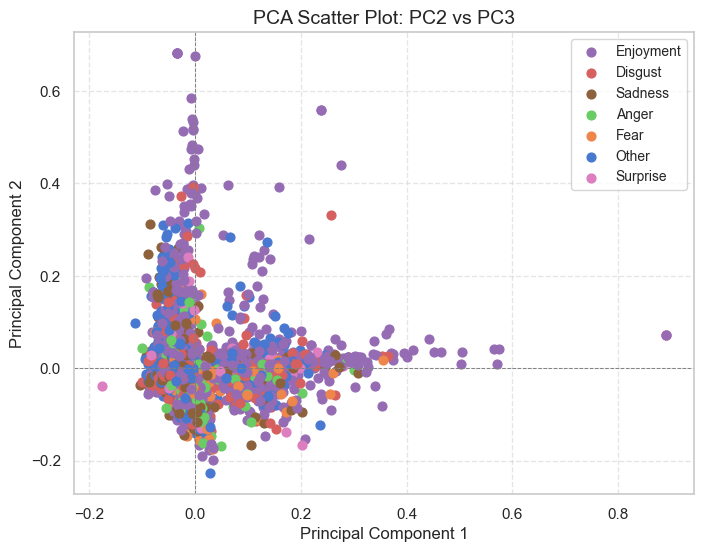

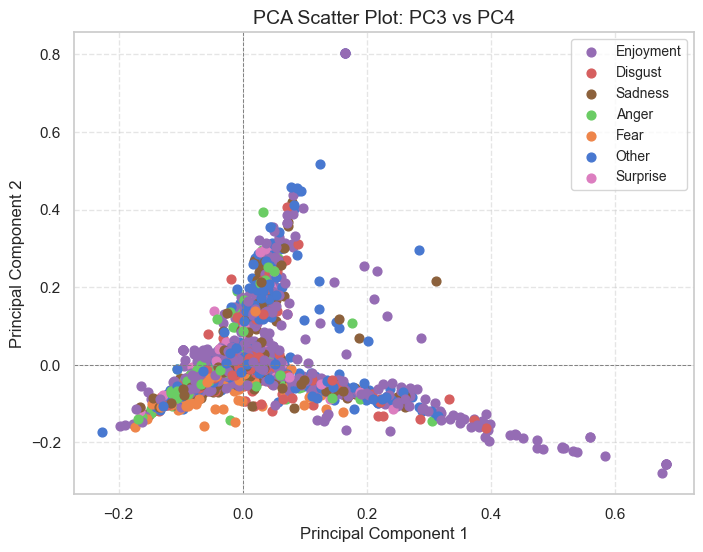

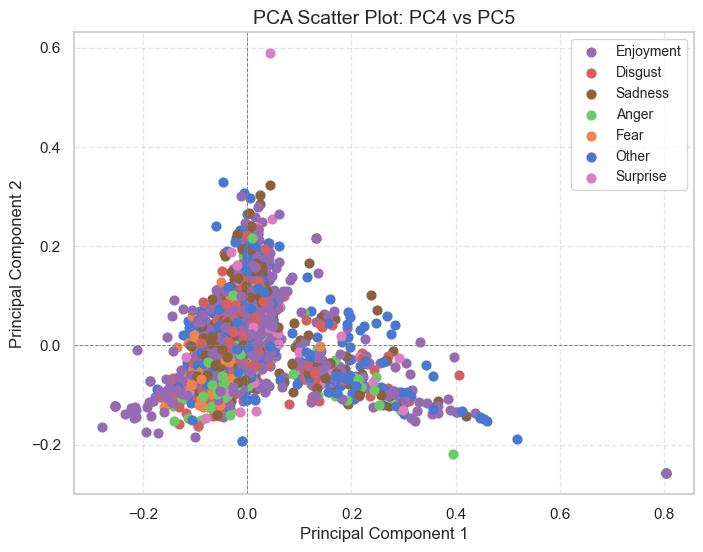

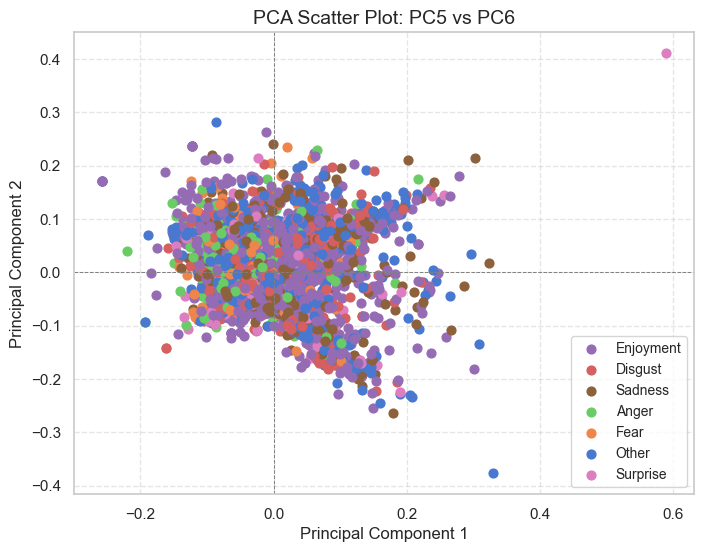

In [25]:
pairs = [(0,1), (0,2), (1,2), (2,3), (3,4), (4,5)]  # ví dụ 6 chiều đầu

for i, j in pairs:
    pc1 = X_train_pca_df[f'PC{i+1}']
    pc2 = X_train_pca_df[f'PC{j+1}']
    plot_scatter(pc1, pc2, X_train_pca_df['Emotion'], 
                 title=f"PCA Scatter Plot: PC{i+1} vs PC{j+1}")

### Mối quan hệ của 6 TPC đầu tiên với đầu ra

C:\Users\Admin\AppData\Local\Temp\ipykernel_15436\1141765362.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_train_pca_df, x='Emotion', y=f'PC{i+1}', palette='pastel')


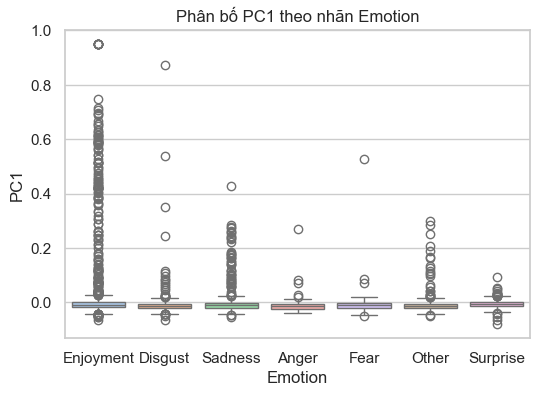

C:\Users\Admin\AppData\Local\Temp\ipykernel_15436\1141765362.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_train_pca_df, x='Emotion', y=f'PC{i+1}', palette='pastel')


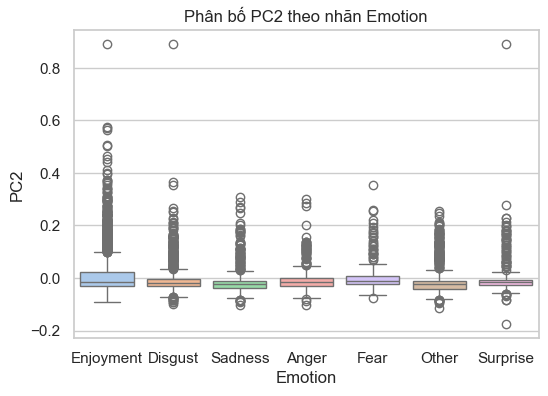

C:\Users\Admin\AppData\Local\Temp\ipykernel_15436\1141765362.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_train_pca_df, x='Emotion', y=f'PC{i+1}', palette='pastel')


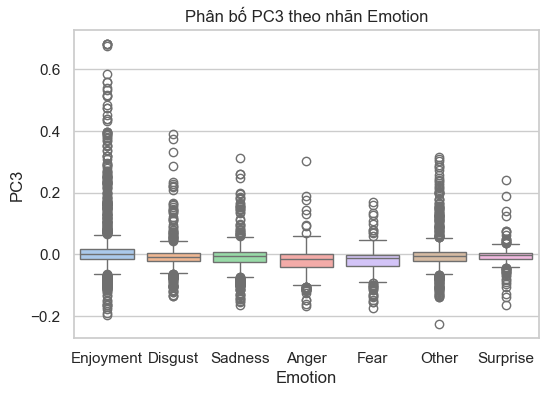

C:\Users\Admin\AppData\Local\Temp\ipykernel_15436\1141765362.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_train_pca_df, x='Emotion', y=f'PC{i+1}', palette='pastel')


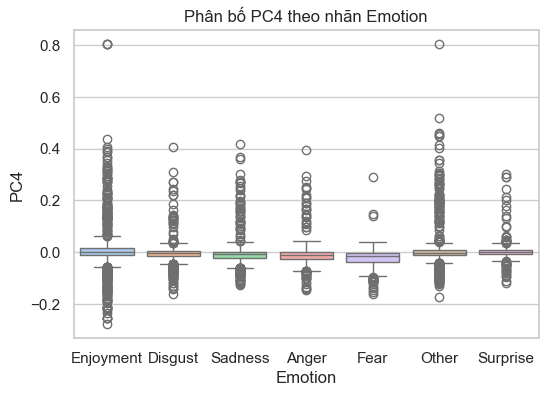

C:\Users\Admin\AppData\Local\Temp\ipykernel_15436\1141765362.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_train_pca_df, x='Emotion', y=f'PC{i+1}', palette='pastel')


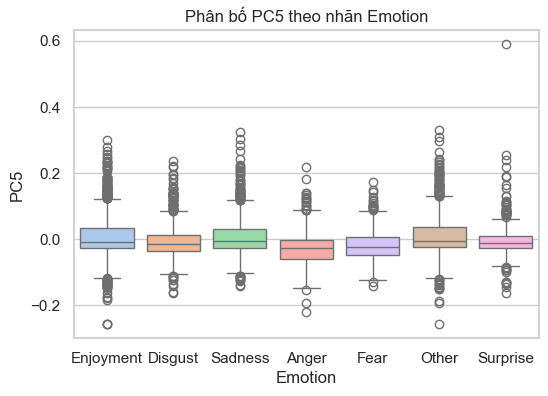

C:\Users\Admin\AppData\Local\Temp\ipykernel_15436\1141765362.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_train_pca_df, x='Emotion', y=f'PC{i+1}', palette='pastel')


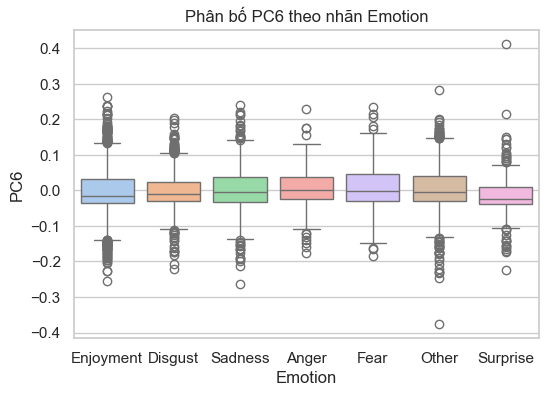

In [26]:
for i in range(6):
    plt.figure(figsize=(6,4))
    sns.boxplot(data=X_train_pca_df, x='Emotion', y=f'PC{i+1}', palette='pastel')
    plt.title(f'Phân bố {f"PC{i+1}"} theo nhãn Emotion')
    plt.xlabel('Emotion')
    plt.ylabel(f'PC{i+1}')
    plt.show()

Nhận xét: Hầu hết 6 TPC đều không phân biệt rõ cảm xúc, tức là do PCA chưa khai thác được cấu trúc cảm xúc (có thể do phương pháp embedding chưa đủ ngữ nghĩa của câu chẳng hạn)

In [27]:
# Phân tích ANOVA: chưa biết đề làm gì :<
from scipy.stats import f_oneway

groups = [X_train_pca_df[X_train_pca_df['Emotion'] == emo]['PC1'] for emo in X_train_pca_df['Emotion'].unique()]
f_stat, p_val = f_oneway(*groups)
print(f"F-statistic: {f_stat:.3f}, p-value: {p_val:.5f}")


F-statistic: 31.959, p-value: 0.00000


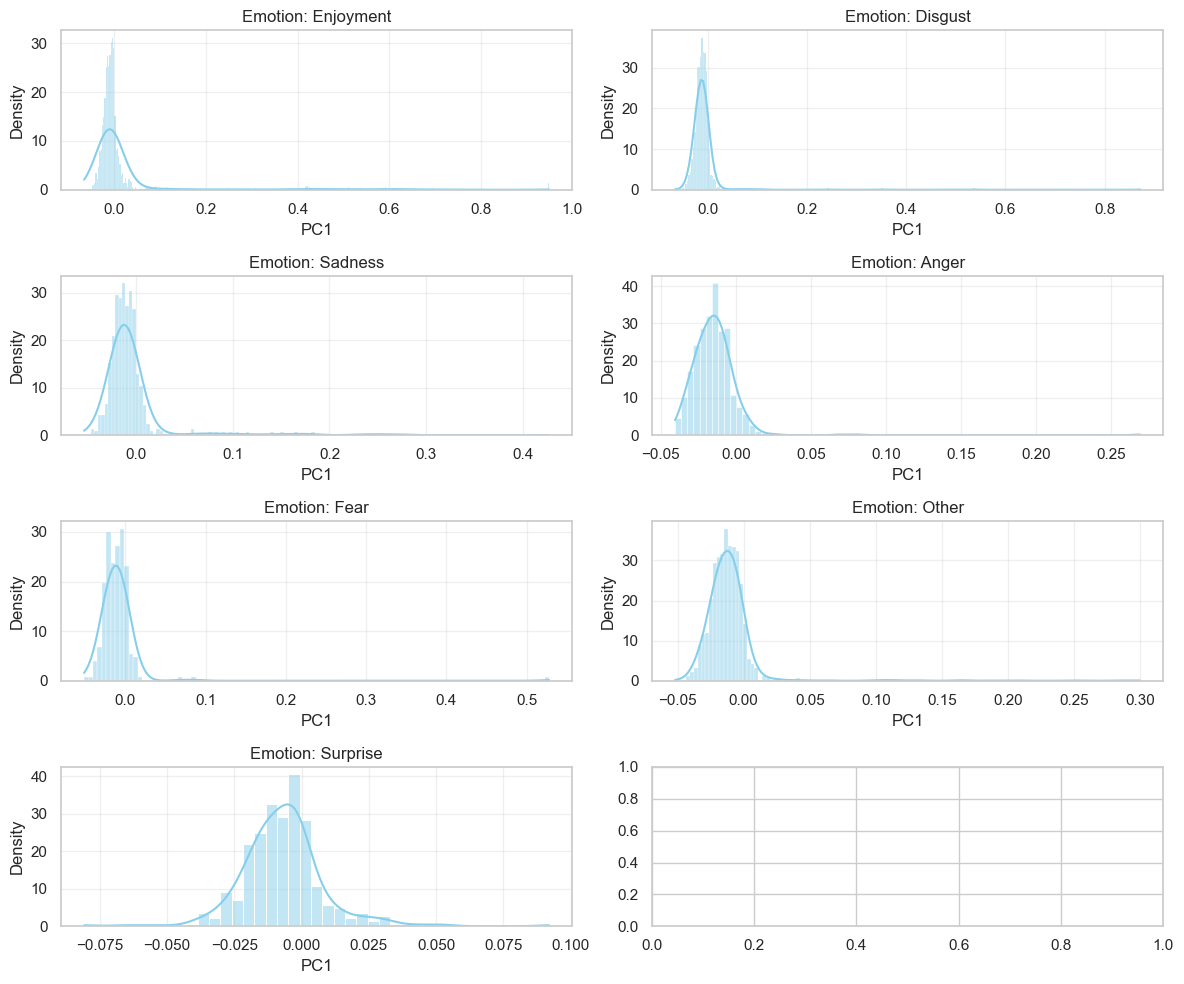

In [28]:
# Vẽ bằng histogram thì xem phân phối DL rõ hơn, nhưng box plot xem được trung vị
emotions = X_train_pca_df['Emotion'].unique()
n = len(emotions)
fig, axes = plt.subplots(nrows=(n//2 + n%2), ncols=2, figsize=(12, 10))

for ax, emo in zip(axes.flatten(), emotions):
    sns.histplot(data=X_train_pca_df[X_train_pca_df['Emotion']==emo],
                 x='PC1', kde=True, stat='density', color='skyblue', ax=ax)
    ax.set_title(f'Emotion: {emo}')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Density: mật độ

## LDA

- Tìm ma trận W chiếu DL vào không gian LDA
- Sau khi học được W, tính các hàm phân biệt tuyến tính (linear discriminats) để dự đoán lớp 
- Thay vì mỗi TPC giữ một phần thông tin như PCA, thì LDA sẽ giữ một phần thông tin giúp phân biệt giữa các lớp
- Vì thế, LDA có thể giảm còn số chiều max là (n-1) chiều (n là số nhãn)

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [30]:
X_train_arr.shape

(6036, 7991)

### LDA còn 6 chiều

In [31]:
lda = LinearDiscriminantAnalysis(n_components=6)
X_train_lda =lda.fit_transform(X_train_arr, y_train)

### In các tham số tuyến tính cho bài toán phân loại 
Hàm phân biệt:

theta_k(x) = x^T. sum^(-1)(u_k) - 1/2 * u_k^T. sum^(-1)(y_k) + log(P(C_k))

In [32]:
# In ra các tham số tuyến tính cho bài toán phân loại
print("Hệ số hàm phân biệt:")
print(lda.coef_)      # Hệ số của hàm phân biệt (mỗi hàng là 1 lớp)
print()
print("Hệ số chặn:")
print(lda.intercept_) # bias theta_k(x) = w_k^Tx + b_k,   w_k là coef

Hệ số hàm phân biệt:
[[ 1559.76705668 -1243.5872139   2124.11690604 ... -1986.42708059
   2629.73345494  2886.71043567]
 [  261.7299428   1096.24553755  -556.85942511 ...  1491.11127662
  -2139.40895135 -1059.69090435]
 [ -259.85681285   497.24928196  -918.03337476 ...   188.7336517
   -445.29671697  -571.72866597]
 ...
 [ -347.37998274  -633.21590393   356.48689803 ...   765.33230919
   -620.9607847    652.9236125 ]
 [  274.30782681 -1615.24476311  -537.39035546 ... -2657.7555051
   1491.38742411  -314.82777591]
 [ -535.72187581   453.61885133   199.11803996 ...   417.01401076
   -981.10959449  -508.94467244]]

Hệ số chặn:
[-1418.72846095  -394.80475791   -37.89320302 -3845.45293636
  -190.30802326  -782.25838388  -132.2557105 ]


In [33]:
X_train_lda.shape

(6036, 6)

- LDA tìm ra 6 hướng giúp phân biệt tâm của 7 label
- Các vector riêng của S_w^-1 * S_B mô tả toàn bộ thông tin phân biệt giữa các lớp, tức là TOÀN BỘ KHẢ NĂNG PHÂN BIỆT đã ở trong 6 chiều này 

In [34]:
# Tỉ lệ phương sai giải thích của từng thành phần
print("Tỉ lệ phương sai giải thích cùa 6 thành phần:", lda.explained_variance_ratio_)

# Tổng phương sai giữ lại
print("Tổng phương sai giải thích (phương sai tích lũy):", lda.explained_variance_ratio_.sum())

Tỉ lệ phương sai giải thích cùa 6 thành phần: [0.32693235 0.21892687 0.19193488 0.15488211 0.07980591 0.02751788]
Tổng phương sai giải thích (phương sai tích lũy): 1.0000000000000002


### Trực quan hóa phương sai giải thích

In [35]:
# Lấy tỷ lệ phương sai giải thích 
explained_variance_ratio = lda.explained_variance_ratio_ * 100  # chuyển sang %
n_components = len(explained_variance_ratio)

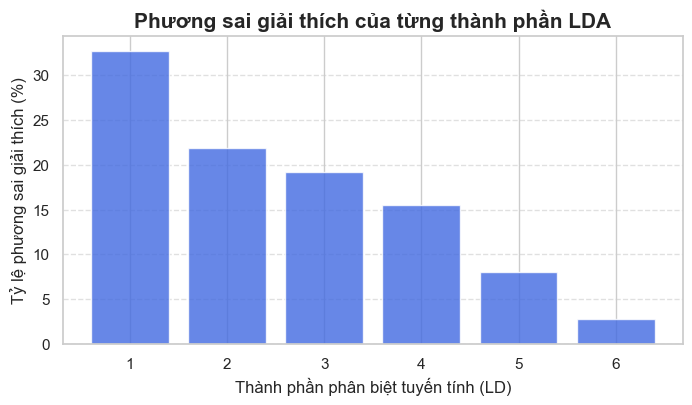

In [36]:
# Vẽ biểu đồ cột
plt.figure(figsize=(8, 4))
plt.bar(range(1, n_components + 1), explained_variance_ratio,alpha = 0.8, color = 'royalblue')
plt.ylabel('Tỷ lệ phương sai giải thích (%)')
plt.xlabel('Thành phần phân biệt tuyến tính (LD)')
plt.title('Phương sai giải thích của từng thành phần LDA', fontsize=15, fontweight ='bold')
plt.xticks(range(1, n_components + 1))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Trực quan DL theo từng cặp TPC 

In [37]:
# Chuyển thành df
train_lda_df = pd.DataFrame(
    X_train_lda,
    columns=[f'LD{i+1}' for i in range(X_train_lda.shape[1])]
)
train_lda_df['Emotion'] = y_train.values  # thêm nhãn cảm xúc

In [38]:
# Thiết lập style chung
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'bold'

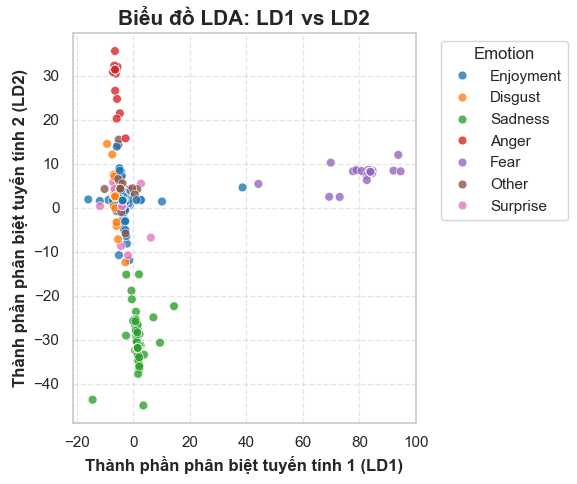

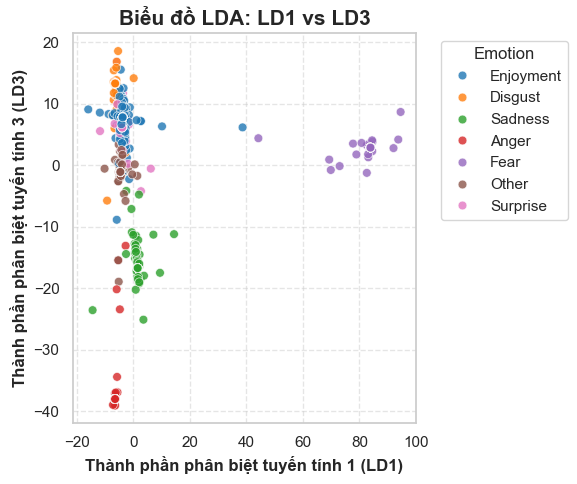

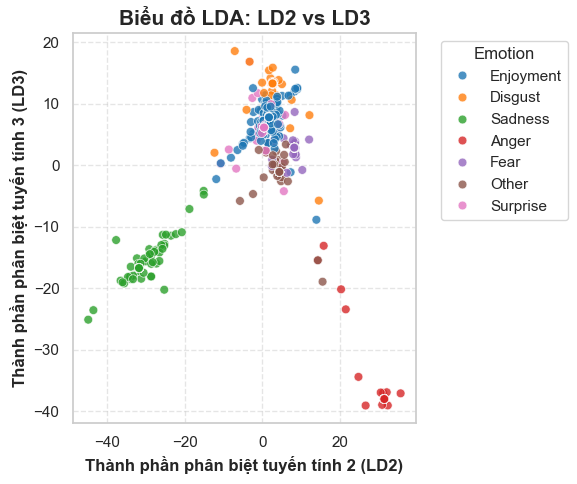

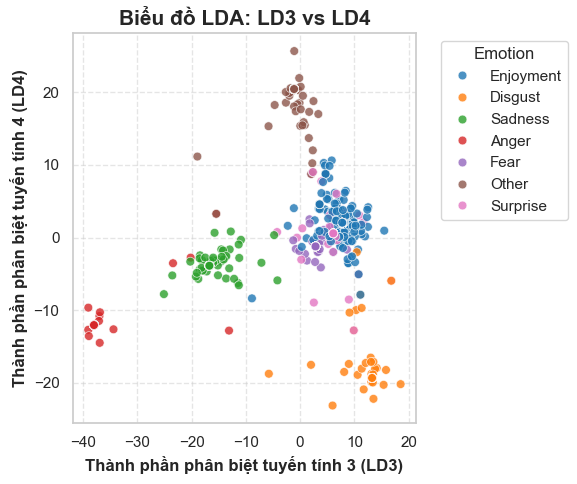

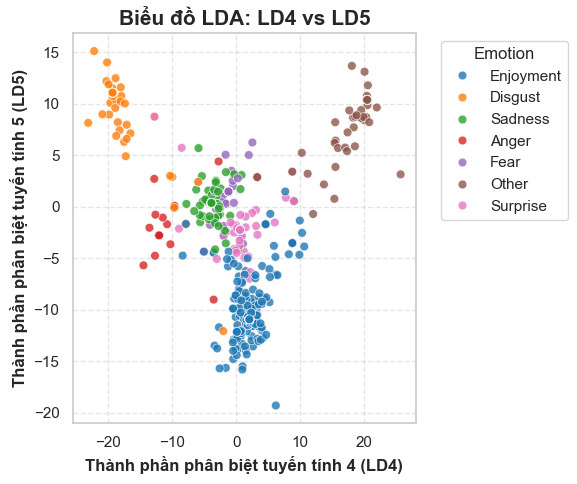

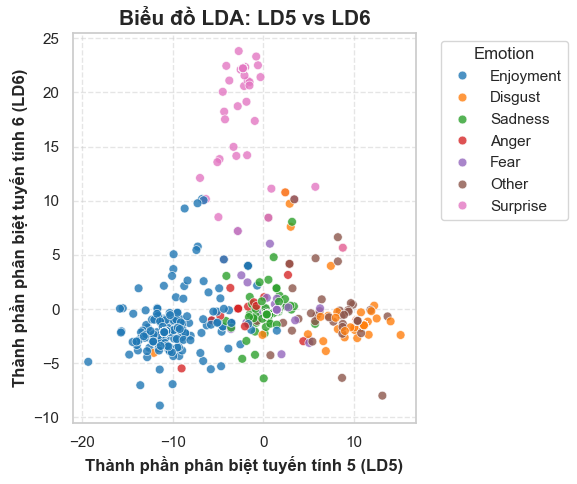

In [39]:
sns.set_palette("tab10")  # hoặc "Set2", "Dark2", "Paired"

for i, j in pairs:
    plt.figure(figsize=(6,5))
    sns.scatterplot(
        data=train_lda_df,
        x=f'LD{i+1}', y=f'LD{j+1}',
        hue='Emotion',
        alpha=0.8, s=40
    )
    
    plt.title(f'Biểu đồ LDA: LD{i+1} vs LD{j+1}')
    plt.xlabel(f'Thành phần phân biệt tuyến tính {i+1} (LD{i+1})')
    plt.ylabel(f'Thành phần phân biệt tuyến tính {j+1} (LD{j+1})')
    plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

Nhận xét: Sau khi dùng LDA, các lớp đã được phân biệt rõ hơn, đặc biệt ở TPC1 với TPC2 và TCP3

### Vẽ cách 2 (nhưng mà cách này chạy lâu)

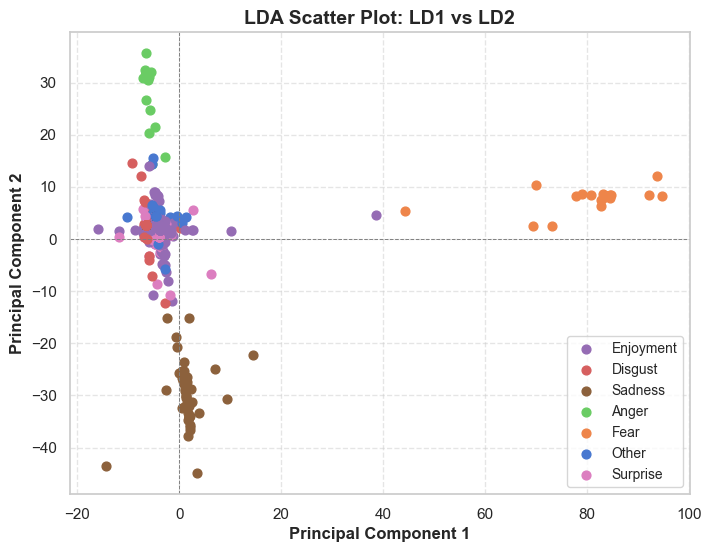

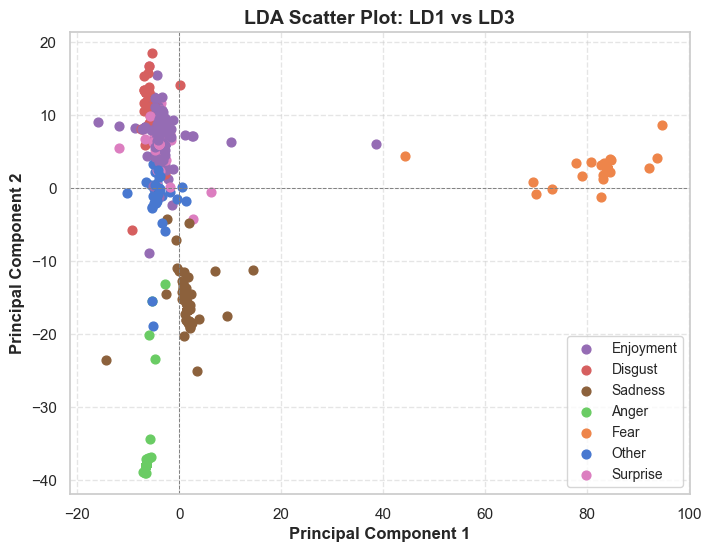

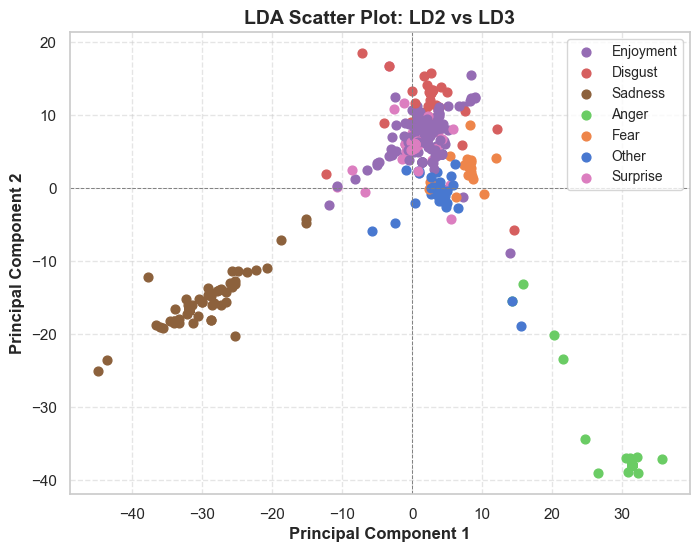

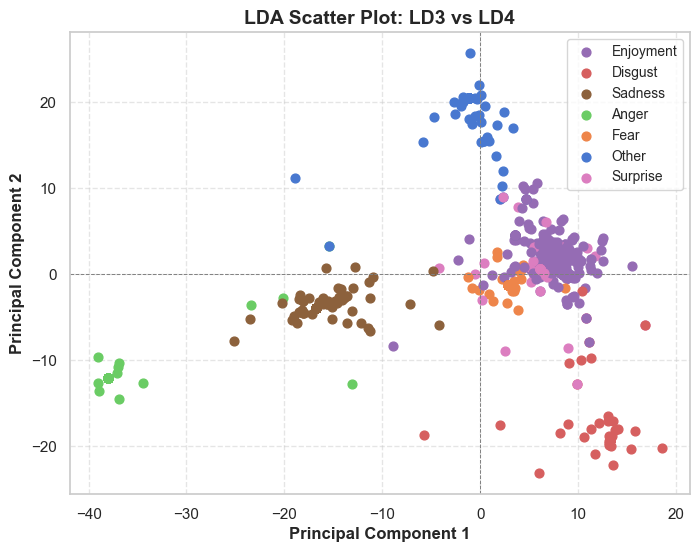

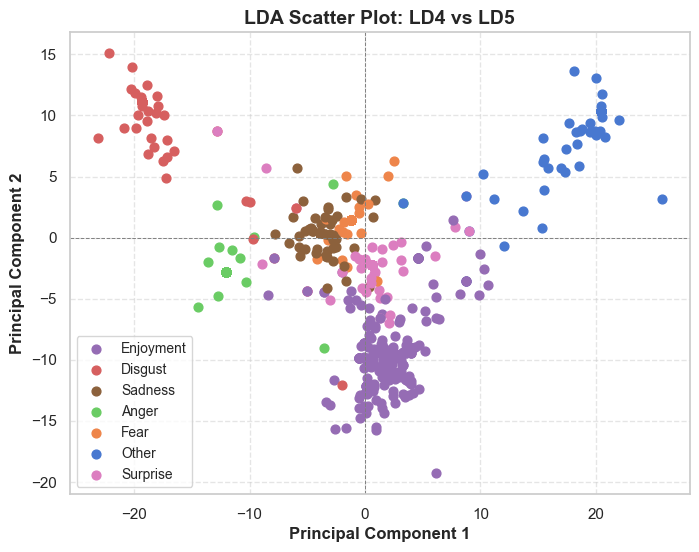

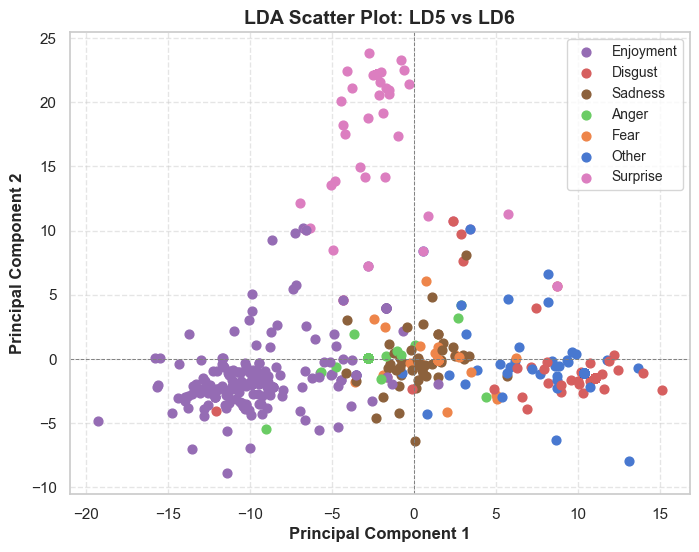

In [40]:
pairs_lda = [(0,1), (0,2), (1,2), (2,3), (3,4), (4,5)]  

for i, j in pairs_lda:
    lda1 = train_lda_df[f'LD{i+1}']
    lda2 = train_lda_df[f'LD{j+1}']
    plot_scatter(lda1, lda2, X_train_pca_df['Emotion'], 
                 title=f"LDA Scatter Plot: LD{i+1} vs LD{j+1}")

### Mối quan hệ của 6 TPC đầu tiên với các nhãn

C:\Users\Admin\AppData\Local\Temp\ipykernel_15436\3842135148.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_lda_df, x='Emotion', y=f'LD{i+1}', palette='tab10')


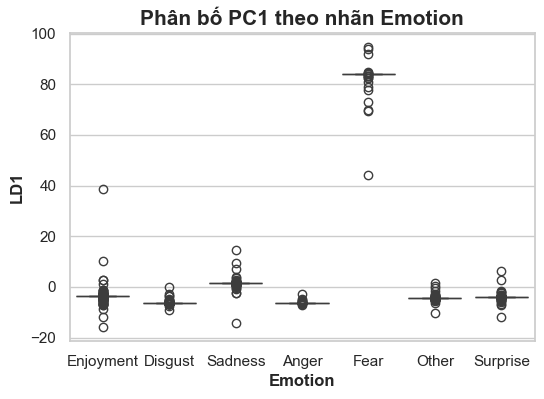

C:\Users\Admin\AppData\Local\Temp\ipykernel_15436\3842135148.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_lda_df, x='Emotion', y=f'LD{i+1}', palette='tab10')


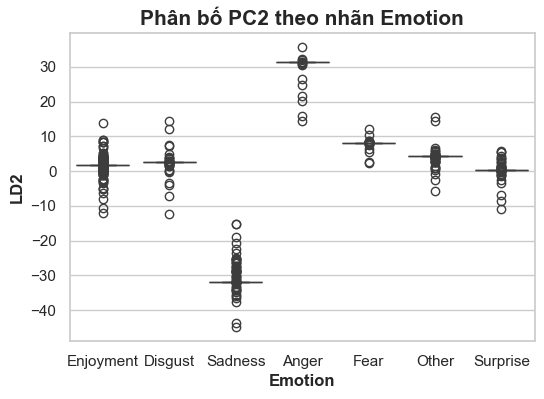

C:\Users\Admin\AppData\Local\Temp\ipykernel_15436\3842135148.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_lda_df, x='Emotion', y=f'LD{i+1}', palette='tab10')


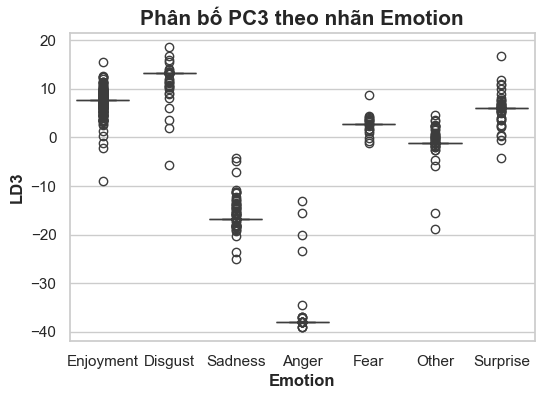

C:\Users\Admin\AppData\Local\Temp\ipykernel_15436\3842135148.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_lda_df, x='Emotion', y=f'LD{i+1}', palette='tab10')


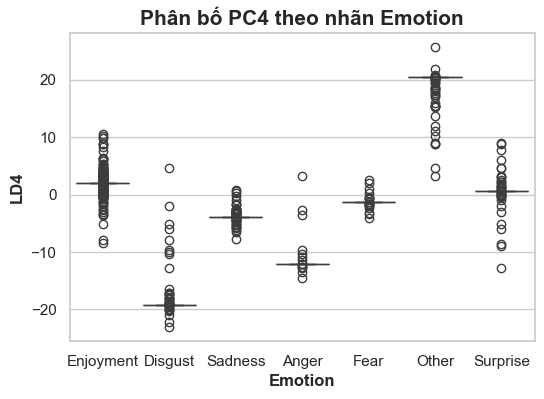

C:\Users\Admin\AppData\Local\Temp\ipykernel_15436\3842135148.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_lda_df, x='Emotion', y=f'LD{i+1}', palette='tab10')


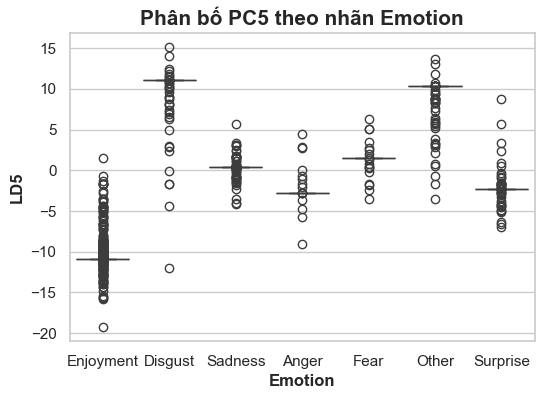

C:\Users\Admin\AppData\Local\Temp\ipykernel_15436\3842135148.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_lda_df, x='Emotion', y=f'LD{i+1}', palette='tab10')


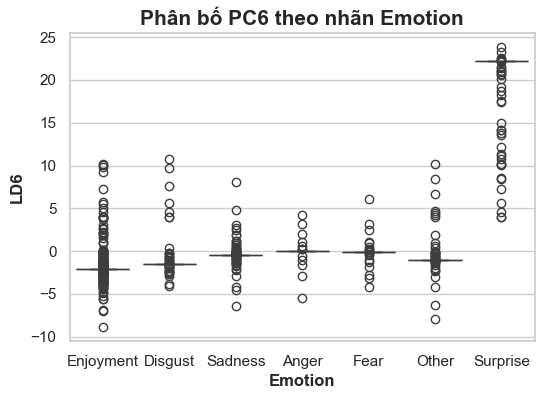

In [41]:
for i in range(6):
    plt.figure(figsize=(6,4))
    sns.boxplot(data=train_lda_df, x='Emotion', y=f'LD{i+1}', palette='tab10')
    plt.title(f'Phân bố {f"PC{i+1}"} theo nhãn Emotion')
    plt.xlabel('Emotion')
    plt.ylabel(f'LD{i+1}')
    plt.show()